# SMAI Assignment - 3

## Question - `2` : Gaussian Mixture Models

Resources: 
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html 

- A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 
- One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

There are, however, a couple of advantages to using Gaussian mixture models over k-means.
- k-means does not account for variance(width of the bell shape curve). In multiple dimensions, covariance matrix determines the shape of the distribution.
- K-means performs hard classification whereas GMM performs soft classification, i.e. in k-means, data point is deterministically assigned to one and only one cluster, but in reality there may be overlapping between the cluster GMM provide us the probabilities of the data point belonging to each of the possible clusters.

![GMM](./extras/gmm.png)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal
import cv2

In [17]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None, save=False, save_name=None):
    eps = 0.0001
    
    img = img.astype(np.float64)
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + eps)
    
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    fig.tight_layout()
    
    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('off')
    
    if save:
        if save_name is None:
            save_name = title
            
        # plt.imsave(f'../imgs/{save_name}.png', img)
        plt.savefig(f'../results/{save_name}.png', bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

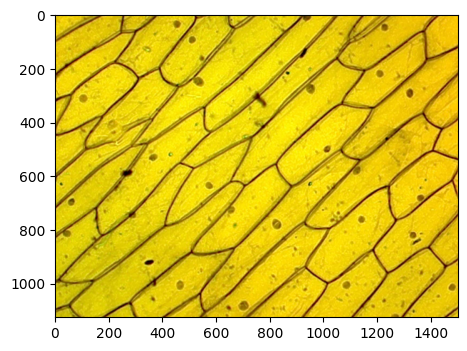

In [19]:
path = "/content/drive/My Drive/ColabNotebooks/SMAI_Assignment_3/Q2/images/plant_cells.jpg"
img = cv2.imread(path)
plot_rgb(img)

# GMM Implementation

- The main difficulty in learning Gaussian mixture models from unlabeled data is that one usually doesn’t know which points came from which latent component (if one has access to this information it gets very easy to fit a separate Gaussian distribution to each set of points). 
- Expectation-maximization (EM) is a well-founded statistical algorithm to get around this problem. (EM) algorithm is an iterative method to find (local) maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables.
- The EM iteration alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. These parameter-estimates are then used to determine the distribution of the latent variables in the next E step.
-  Repeating this process is guaranteed to always converge to a local optimum.

![GMM](./extras/gmm_plot.png)

Some details: 
- The choice of initialization is left upto you:
    - You can use `sklearn` libraries to assist you in initializing the means (eg. KMeans, Random, etc.)
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.

In [4]:
"""
This is a *very rough* template of how you *could* go about implementing your GMM class.
And you are *strongly suggested* to make changes and add methods accordingly.

Note that this is *NOT a requirement*, it's just a suggestion that you should follow Class based  implementation as it might help later.
But as long as your code works, it doesn't matter if have this type of implementation or not.
"""

class GMM:
    
    # self.weights = None
    # self.means = None
    # self.covars = None
    
    def __init__(self, n_components=2, tol=1e-3, max_iter=10):
        """
        A Gaussian mixture model trained via the expectation maximization
        algorithm.
        
        Parameters
        ----------
        n_components: The number of mixture components.
        tol: The convergence threshold
        """
        self.k = n_components
        #number pf clusters
        self.max_iter = max_iter
        self.tol = tol

    def initialize_params(self, X, kmeans=False):
        """
        Initialize the starting GMM parameters.
        
        Parameters
        ----------
        X : A collection of `N` training data points, each with dimension `d`.
        kmeans: A boolean flag for determining if to initialize the params with kmeans or randomly.
        """
        self.shape = X.shape
        #let k = 3
        # Create a dataset X of 100 samples with 2 features
        # X = np.random.randn(100, 2)
        self.row , self.col = self.shape

        #the initial probabilities for each cluster. In this case, 
        # it is initialized with a uniform prior of 1/k for all clusters.
        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        # output :[0.33333333 0.33333333 0.33333333]

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        '''output = [[0.33333333 0.33333333 0.33333333]
                        .............................
                     [0.33333333 0.33333333 0.33333333]]
        '''
        random_row = np.random.randint(low=0, high=self.row, size=self.k)
        '''             
        This generates 3 random row indices between 0 and 99 
        (since low=0 and high=100) and selects the corresponding
          rows from X to use as the initial means of the 3 Gaussians.
          [42, 88, 8]
        '''


        # initial value of mean of k Gaussians
        self.means = [X[row_index, :] for row_index in random_row] 

        # initial value of covariance matrix of k Gaussians
        # self.sigma = [np.cov(X.T) for _ in range(self.k)] 
        # theta =(mu1,sigma1,mu2,simga2......muk,sigmak)
        self.sigma = []
        for _ in range(self.k):
            self.sigma.append(np.cov(X.T))
        
    # E-Step: update weights and phi holding mu and sigma constant
    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters
        
        Parameters
        ----------
        X : A collection of `N` data points, each with dimension `d`.
        """
        # updated weights or P(Xi/Ci=j)
        self.weights = self.predict_probability(X)
        # for i in range(self.k):
        #     self.weights[:,i] = self.phi[i]*multivariate_normal.pdf(X,
        #                                                      means=self.mean[i],
        #                                                      cov =self.sigma[i])
        # self.weights = self.weights / self.weights.sum(axis=1)[:, np.newaxis]
        # mean of sum of probability of all data points wrt to one cluster
        #  is new updated probability of cluster k or (phi)k
        self.phi = self.weights.mean(axis=0)


    # M-Step: update meu and sigma holding phi and weights constant
    def M_step(self, X):
        """
        Updates parameters maximizing the expected log-likelihood found on the E step.
        
        Parameters
        ----------
        X : A collection of `N` data points, each with dimension `d`.
        """
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()

            self.means[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)


    
    def predict_probability(self,X):
        # Creates a n*k matrix denoting probability of each point wrt each cluster
        likelihood = np.zeros((self.row, self.k))
        # likelihood = np.zeros(self.row, self.k)
        for i in range(self.k):
            gaussian_dis = multivariate_normal(mean = self.means[i],cov=self.sigma[i])
            likelihood[:,i] = gaussian_dis.pdf(X)

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights



    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.
        
        Parameters
        ----------
        X : A collection of `N` training data points, each with dimension `d`.
        y: not used
        """
        self.initialize_params(X)
        # plt.figure(figsize=(16, 25))
        # for iteration in range(self.max_iter):
        #     permutation = np.array([mode(iris.target[gmm.predict(X) == i]).mode.item() for i in range(gmm.k)])
        #     permuted_prediction = permutation[gmm.predict(X)]
        #     print('\nThe accuracy of the permuted prediction against target before iteration ',iteration+1,end="")
        #     print(': ',np.mean(iris.target == permuted_prediction))
        #     print('\n')
        #     confusion_matrix(iris.target, permuted_prediction)
        #     plt.title(' Iteration Cluster')
        #     plt.subplot(5,3,iteration+1)
        #     clusters=permuted_prediction
        #     plt.xlabel(iris.feature_names[0])
        #     plt.ylabel(iris.feature_names[1])
        #     plt.scatter(jitter(X[:, 0]), jitter(X[:, 1]), c=clusters, cmap=plt.cm.get_cmap('brg'),marker='.')
        #     plt.grid()
        #     plt.tight_layout()
        #     # iterate to update the value of P(Xi/Ci=j) and (phi)k
        #     self.e_step(X)
        #     # iterate to update the value of meu and sigma as the clusters shift
        #     self.m_step(X)
        for iteration in range(self.max_iter):
            self.E_step(X)
            self.M_step(X)
        
    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        
        Parameters
        ----------
        X : A collection of `M` data points, each with dimension `d`.
        
        Returns
        -------
        Predicted labels.
        """
        weights = self.predict_probability(X)
        return np.argmax(weights,axis=1)

# Semantic Segmentation

- Semantic segmentation, or image segmentation, is the task of clustering parts of an image together which belong to the same object class. 
- It is a form of pixel-level prediction because each pixel in an image is classified according to a category.

(Note: The label texts on the image are not part of the expected output)

![SS](./extras/segmentation_reference.png)

## Unsupervised 

- One of the most popular and unsupervised way to perform Semantic Segmentation on unlabelled data is clustering
- In this section we are going to compare different clustering methods by selecting different number of components for each and visualizing.
- We can treat our Image as a distribution in the RGB space (or Grayscale/Intensity depending on your approach) and each pixel would act as a data point for the distribution.
- Using GMMs we would learn the nature of the distribution.
- Similar to K-Means we would assign the label to each pixel based on the weighted log-probabilities with each Gaussian.

In [35]:
import os
os.chdir("drive/My Drive/ColabNotebooks/SMAI_Assignment_3/Q2")


FileNotFoundError: ignored

In [21]:
source_folder = './images'
img_name = 'plant_cells_2.jpeg'

img_path = f'{source_folder}/{img_name}'

In [22]:
print(img_path)

./images/plant_cells_2.jpeg


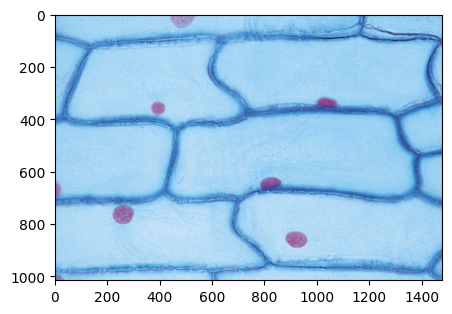

In [23]:
test_img = cv2.imread(img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plot_rgb(test_img, figsize=(5, 5))

In [ ]:
test_img.shape

(1015, 1480, 3)

## Fit your GMM Model to the Image
- Fit the given image to your GMM model for different number of `components` / `clusters` / `gaussians`. (At least 3)
- You could also use different images from the `images` folder, but make sure to use that image for visualizations and predictions.

In [ ]:
"""
Create and Fit Multiple GMMs corresponding to different number of components
"""

test_img = test_img.reshape(-1, 3)
print(test_img.shape)
print(test_img[0])
num=np.linalg.norm(test_img)
test_img=(test_img/num)
# Fit the GMM model with 3 components
gmm = GMM()
gmm.fit(test_img)

# Get the predicted cluster labels for each pixel
labels = gmm.predict(test_img)

(1502200, 3)
[121 186 226]


In [ ]:
labels = labels.reshape(1015, 1480)

## Predict and Visualize Segmented Maps

- Based on your fitted model, predict the label for each pixel
    - Here, by label we mean which `gaussian` / `component` the pixel belongs to.
- Below you have been given a reference code for plotting segmentation maps. You can implement your own function, but just make sure segmented maps are clearly visible and distinct.
- You are expected to visualize the segmentation maps for multiple values of `components` and observe the differences (at least 3)

In [24]:
def plot_seg(img, figsize=None, cmap=None, title=None, xlabel=None, ylabel=None, save=False, save_name=None):
    """
    Funciton for Plotting Segmentation Maps.
    Expected Input: 2D Matrix of the size of the image containing just label values (1, 2, 3, ...) instead of [R, G, B] / Grayscale values.
    """
    
    img = np.copy(img)
    n_class = np.max(img) + 1 ## Could remove +1 depending on how you constructed segmented maps
    
    colors = []
    for i in range(n_class):
        colors.append(( np.random.randint(256), np.random.randint(256), np.random.randint(256)))
    
    colors = np.asarray(colors, dtype=np.uint8)
    
    
    fig = plt.figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    fig.tight_layout()
    
    img = colors[img]
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('off')
    
    if save:
        if save_name is None:
            save_name = title
            
        # plt.imsave(f'../imgs/{save_name}.png', img)
        plt.savefig(f'../results/{save_name}.png', bbox_inches='tight')
    
    plt.imshow(img, cmap=cmap)
    plt.show()

    plt.close(fig)

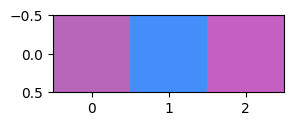

In [ ]:
"""
Testing out the function
"""

plot_seg([[0, 1, 2]], figsize=(3, 1))

In [ ]:
"""
Predict the Labels for each pixel to get segmentation maps corresponding to different number of components

"""
labels = []

n_components = [2,3,4,5]

for i in range(len(n_components)):
  gmm = GMM(n_components[i])
  gmm.fit(test_img)
  labels.append(gmm.predict(test_img))

# Get the predicted cluster labels for each pixel
pred = []
for i in range(len(n_components)):
  label = labels[i].reshape(1015,1480)
  pred.append(label)

In [ ]:
pred[0].shape

(1015, 1480)

num_of_components =  2


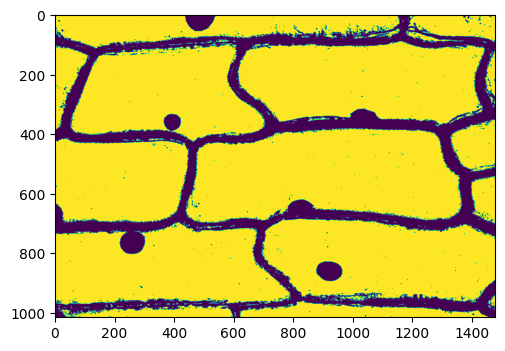


num_of_components =  3


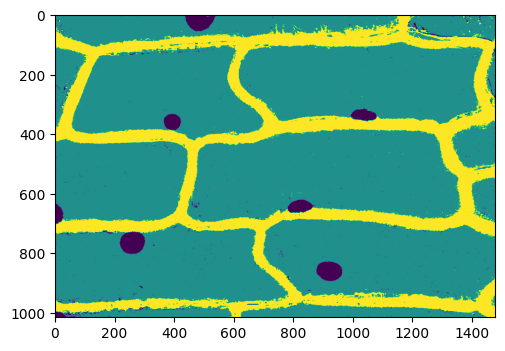


num_of_components =  4


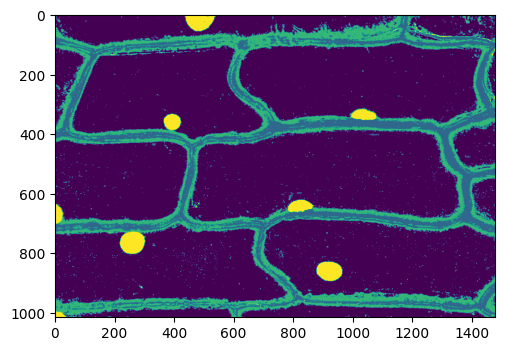


num_of_components =  5


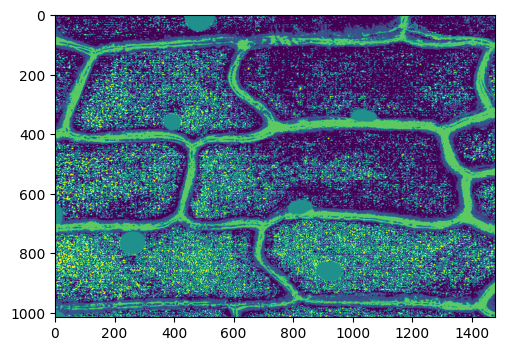

In [ ]:
"""
Visualize the segmentation maps using given helper function
"""
for i in range(len(n_components)):
  print("num_of_components = ",n_components[i])
  plot_rgb(pred[i])
  print()

In [ ]:
for i in range(len(n_components)):
  print("num_of_components = ",n_components[i])
  plot_seg(pred[i])


## Use KMeans for Comparison

- Perform the same experiment with K-Mean Clustering using `sklearn.cluster.KMeans` and compare the result

In [ ]:
"""
Your code here
"""
#training k-means model
from sklearn.cluster import KMeans
labels = []

n_components = [2,3,4,5]

for i in range(len(n_components)):
  kmeans = KMeans(n_clusters=4)
  kmeans.fit(test_img)
  labels.append(kmeans.predict(test_img))

# Get the predicted cluster labels for each pixel
pred = []
for i in range(len(n_components)):
  label = labels[i].reshape(1015,1480)
  pred.append(label)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


num_of_components =  2


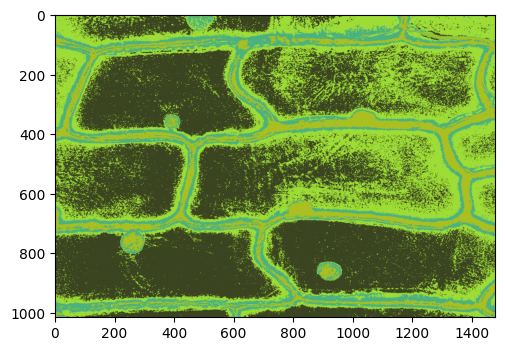

num_of_components =  3


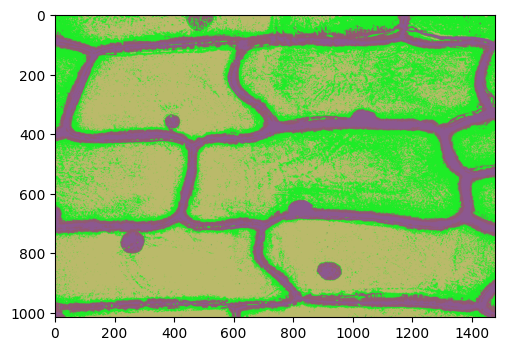

num_of_components =  4


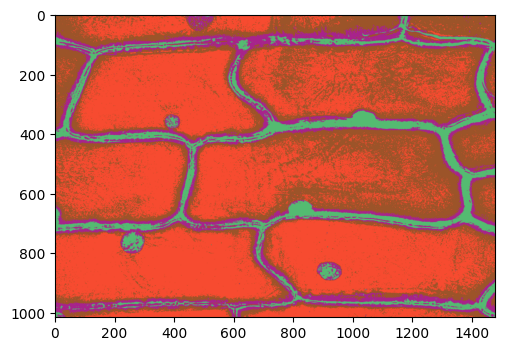

num_of_components =  5


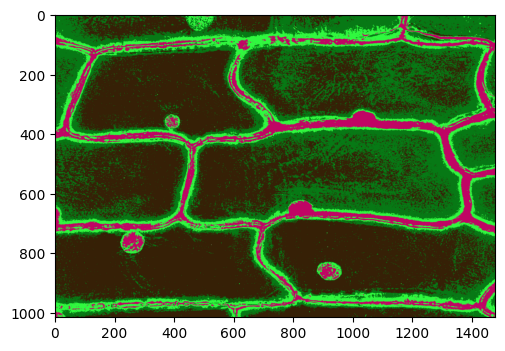

In [ ]:
for i in range(len(n_components)):
  print("num_of_components = ",n_components[i])
  plot_seg(pred[i])

# Background Subtraction

- Foreground detection is one of the major tasks in the field of computer vision and image processing, whose aim is to detect changes in image sequences. 
- Background subtraction is any technique which allows an image's foreground to be extracted for further processing (object recognition, etc.).

One of the most important applications of this is Foreground Detection on Highways for speeding vehicles. 
Before the Deep Learning age, methods using GMMs were considered very effective in accurately detecting vehicles on highways. 

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly. As you can see one of the draws of simply doing this is that changing environments and lighting would severly affect this method, so we are also going to explore Adaptive GMM which takes care of such problems.

![reference](./extras/traffic_reference.gif)

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Hint: Most of the time, the Gaussian with the higher weight corresponds to the background.
    - Hint-2: We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to (baseline - 1).
    To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    This method is much simpler to implement but, this could give worse results.
    
3. K-Means Per Pixel:
    - Similar approach to GMMs per pixel.

4. Adaptive GMM Per Pixel (Not part of the assignment):
    - We can update GMMs without fitting them for every subsequent frame.
    - The biggest advantage of this method is that it can be used in real time tracking and will also adapt to change in environments and lighting.
    - Note: This is not part of the assignment, only meant of enthusiasts who want to explore.In this question, we are going to try different baselines to extract background from low resolution camera footage:

### Extracting Frames from videos

In [7]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [8]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [9]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [10]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

### Loading Frames

In [11]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
    
frames = np.asarray(frames, dtype=np.float64)

### Splitting the data

In [12]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

# train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=True, random_state=1)
train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


## 1. Frame Averaging

### Extract Background Image from the training data

In [14]:
"""
You code here
"""
mean_train_frames = np.mean(train_frames, axis=0)
mean_train_frames


(120, 160, 3)

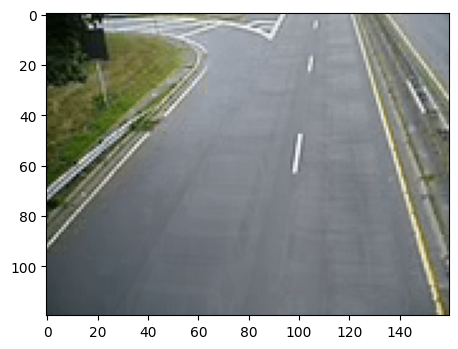

In [34]:
plot_rgb(mean_train_frames)



```
`# This is formatted as code`
```

## 2. GMMs per pixel

### Create Set of GMMs for every pixel and fit them considering every training frame

In [37]:
train_frames[0].shape

(120, 160, 3)

In [ ]:
"""
Your code here
"""
height,width,rgb = train_frames[0].shape
# photo : 3 color channels (RGB)
#  120 rows (height), 60 columns (width)
per_pixel_data = [[] for i in range(height*width)]
for each_photo in train_frames:
  for each_row in range(120):
    for each_col in range(60):
      per_pixel_data = 

'\nYou code here\n'

In [42]:
for frame in train_frames:
    frame = frame.flatten().tolist()
    print(len(frame))
    break

57600


### Extract Background Image from the trained model

In [51]:
"""
Your code here
"""
pixel_data = [[] for i in range(height*width)]
for frame in train_frames:
    for i in range(height):
        for j in range(width):
            pixel = frame[i, j]
            pixel_data[i * width + j].append(pixel)
            print(pixel.shape)
            break
        break
    break
      

(3,)


### Visualize 

In [ ]:
"""
Your code here
"""

'\nYou code here\n'

## 3. Extracting Background using K-Means

- You can use `sklearn.cluster.KMeans` for this classification

### Create Set of K-Means for every pixel and fit them considering every training frame

In [ ]:
"""
Your code here
"""

'\nYou code here\n'

### Extract Background Image from the trained model

In [ ]:
"""
Your code here
"""

'\nYou code here\n'

### Visualize 

In [ ]:
"""
Your code here
"""

'\nYou code here\n'

## Test

- Test the model / approach with the training frames
- You may use any approach that you prefer to achieve background subtraction"
    - Using the corresponding background image extracted earlier. (Bit more efficient but worse visualization)
    - Having per pixel predictions for every subsequent frame using your model. (Less efficient but better visualization)
- You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

### Displaying frames as videos

In [ ]:
def display_frames(frames, fps=10.0):
    eps = 0.0001
    
    wait_time = int(1000 // fps)
    
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break
    
    cv2.destroyAllWindows()

### Saving frames as videos

In [ ]:
def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    eps = 0.0001
    
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")
    # save_path = os.path.join(output_path, f"{file_name.rsplit('.')[0]}.avi")
    
    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
        
        vid_wrt.write(frame)

        
    vid_wrt.release()
    cv2.destroyAllWindows()

### 1. Frame Averaging

In [ ]:
"""
Your code here
"""

'\nYou code here\n'

### 2. GMMs per pixel

In [ ]:
"""
Your code here
"""

'\nYou code here\n'

### 3. KMeans per pixel

- You can use `sklearn.cluster.KMeans` for this classification

In [ ]:
"""
Your code here
"""

'\nYou code here\n'

## 4. Adaptive (Not part of the assignment)
- Reference Paper: http://www.ai.mit.edu/projects/vsam/Publications/stauffer_cvpr98_track.pdf
- Video: https://youtu.be/0nz8JMyFF14
- This part is just for enthusiasts who want to explore some stuff.

In [ ]:
"""
Your code here
"""

'\nYou code here\n'